In [1]:
import projectq
from projectq.ops import All, Measure, QubitOperator, TimeEvolution, X, HGate,Rz
from scipy.optimize import minimize
import numpy as np
import pickle
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [2]:
coeff_hams= np.loadtxt("coeff_hams_more.txt")[:20,:]
bond_distances=np.loadtxt("spacings_more.txt")[:20]
n_samples,n_features=coeff_hams.shape[0],coeff_hams.shape[1]

operator_list=[(),"Z0","Z1","Z2", "Y0 Y1", "X0 X1","Y0 Y2", "X0 X2", "Z0 Z1","Z0 Z2", "Y1 Y2", "X1 X2", "Z1 Z2","X0"]

def ham(coeff_hams,i,bond_distances=bond_distances,dipole=0):
    hamiltonian=coeff_hams[i,0]*QubitOperator(operator_list[0])
    for j in range(1,n_features):
        hamiltonian+=coeff_hams[i,j]*QubitOperator(operator_list[j])
    hamiltonian+=dipole*bond_distances[i]*QubitOperator(operator_list[-1])
    return hamiltonian

In [3]:
hams=[ham(coeff_hams,i) for i in range(n_samples)]

In [4]:
bond_distances

array([0.3       , 0.39591837, 0.49183673, 0.5877551 , 0.68367347,
       0.77959184, 0.8755102 , 0.97142857, 1.06734694, 1.16326531,
       1.25918367, 1.35510204, 1.45102041, 1.54693878, 1.64285714,
       1.73877551, 1.83469388, 1.93061224, 2.02653061, 2.12244898])

In [5]:
def loss_H(theta,ham):
    # Create a ProjectQ compiler with a simulator as a backend

    eng = projectq.MainEngine()
    # Allocate 2 qubits in state |00>
    wf= eng.allocate_qureg(3)
    # Initialize the Hartree Fock state |01>
    X | wf[0]
    X | wf[1]
    X | wf[2]
    # build the operator for ansatz wavefunction
    ansatz_op1 = QubitOperator('X0 Y1')
    ansatz_op2 = QubitOperator('X0 Y2')
    #ansatz_op3 = QubitOperator('X0 Z1')
    # Apply the unitary e^{-i * ansatz_op * t}
    TimeEvolution(theta[0], ansatz_op1) | wf 
    TimeEvolution(theta[1], ansatz_op2) | wf
    #TimeEvolution(theta[1], ansatz_op3) | wf
    # flush all gates
    eng.flush()
    energy = eng.backend.get_expectation_value(ham, wf)
    All(Measure) | wf
    return energy

# fix the Hamiltonian
def landscape_H(thetas,ham):
    es=[]
    for i in range(thetas.shape[0]):
        es.append(loss_H(thetas[i,:],ham))
    return np.array(es).tolist()

# all Hamiltonians
def landscape_Hs(thetas,hams):
    es=[]
    for i in range(len(hams)):
        es.append(landscape_H(thetas,hams[i]))
    return np.array(es)

In [6]:
xs = np.linspace(-np.pi,np.pi,30)
ys = np.linspace(-np.pi,np.pi,30)
#xs = np.linspace(np.pi/2-0.5,np.pi/2+0.5,10)
#ys = np.linspace(np.pi/2-0.5,np.pi/2+0.5,10)
thetas=np.array([[x,y] for x in xs for y in ys])

In [7]:
landscapes=landscape_Hs(thetas,hams[12:13])
landscapes=landscapes.reshape(1,30,30)

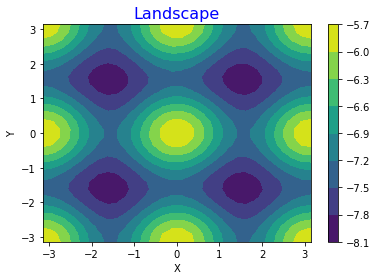

In [8]:
fig=plt.figure()
ax = fig.gca()
x = np.linspace(-np.pi,np.pi,30)
y = np.linspace(-np.pi,np.pi,30)
#x= np.linspace(np.pi/2-1,np.pi/2+1,10)
#y = np.linspace(np.pi/2-1,np.pi/2+1,10)
x, y = np.meshgrid(x, y)#生成网格点
z=landscapes[0,:,:]
# Plot the 3D surface
cset=plt.contourf(x,y,z)
plt.colorbar(cset)

#ax.plot_surface(x, y, z, rcount =100, ccount = 100, cmap ="jet", alpha = 0.8)
#rcount，ccount为绘制曲面时网格片的行数和列数
#help(ax.plot_surface)
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)
#ax.set_zlim(-2, 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
#ax.set_zlabel('Z')
ax.set_title("Landscape",fontsize =16, color ="b")
plt.show()